## Detección de palabras utilizando LSTMs

En este cuaderno se entrenará una red LSTM para detectar ciertas palabras en una secuencia de audio.

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Ajustar la aleatoreidad para tener los mismos resultados
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2025-11-26 22:44:21.241002: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-26 22:44:21.277277: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-26 22:44:23.358804: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### Importando el conjunto de datos mini Speech
Este conjunto de datos es una muestra de speech dataset (speech contiene más de 105.000 archivos de audio). Y consiste en personas diciendo 35 palabras diferentes en inglés. Al descargarse, se tendrán 8 carpetas que tienen los comandos:
- no
- yes
- down
- go
- left
- up
- right
- stop

In [9]:
DATASET_PATH = './data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')


182082353/182082353 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


### Organización del dataset
Creamos un dataloader de tensorflow con las 8 clases vinculadas a las carpetas con los audios

In [2]:
commands = np.array(tf.io.gfile.listdir("data/mini_speech_commands_extracted/mini_speech_commands"))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)


Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [3]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory="data/mini_speech_commands_extracted/mini_speech_commands",
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)


Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.


I0000 00:00:1764215067.467099   57269 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5558 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6



label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [5]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

Eliminando canales extra ya que los audios son mono (un canal)


In [6]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

Creando un tercer dataset de validación a partir del de test


In [7]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [8]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)


(64, 16000)
(64,)


2025-11-26 22:44:39.817551: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
label_names[[1,1,3,0]]


array(['go', 'go', 'no', 'down'], dtype='<U5')

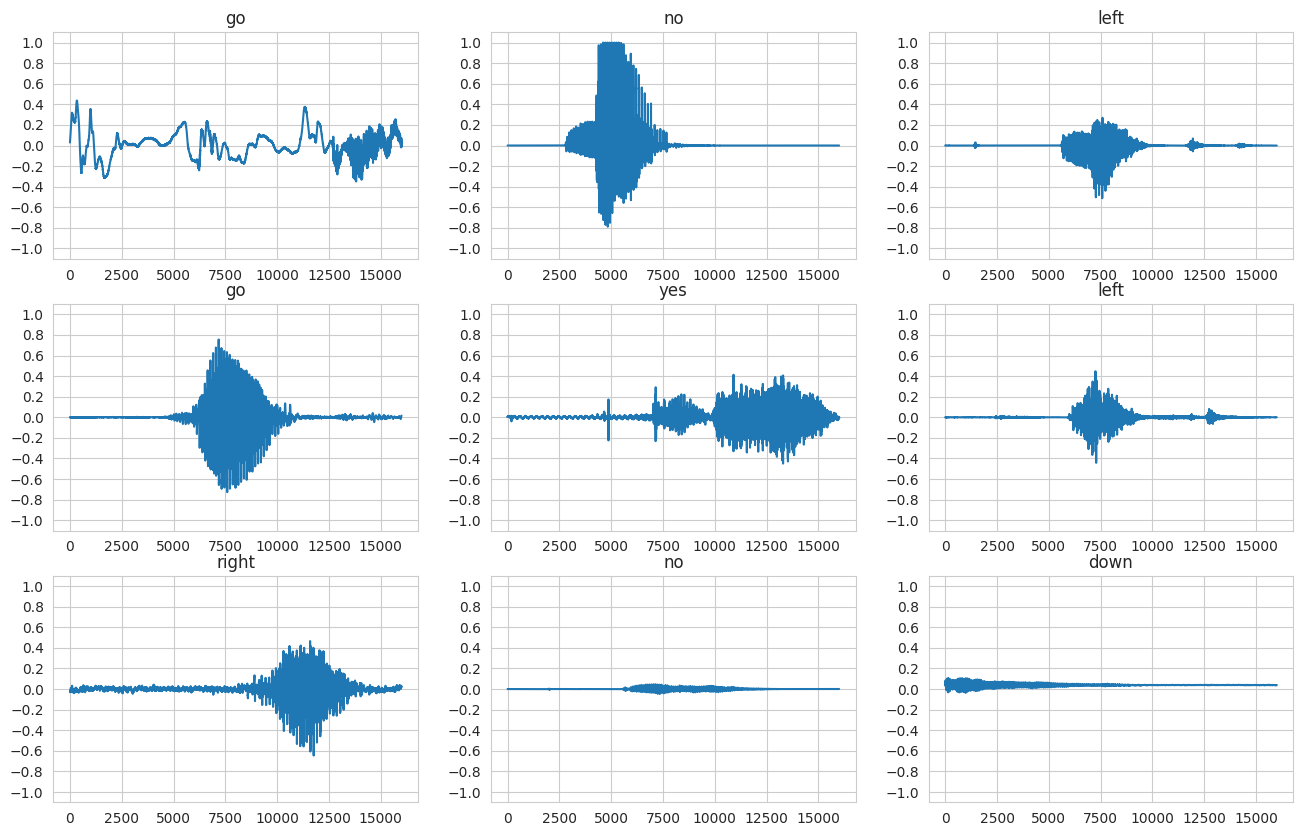

In [10]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])


### Convertir formas de onda en espectrogramas

Las formas de onda en el conjunto de datos están representadas en el dominio del tiempo. A continuación, transformarás esas formas de onda del dominio del tiempo al dominio tiempo-frecuencia mediante el cálculo de la Transformada de Fourier de Tiempo Corto (STFT). Esto permite convertir las formas de onda en espectrogramas, que muestran cómo cambia la frecuencia a lo largo del tiempo y pueden representarse como imágenes 2D. Alimentarás estas imágenes de espectrogramas a tu red neuronal para entrenar el modelo.

Una Transformada de Fourier (tf.signal.fft) convierte una señal en sus componentes de frecuencia, pero pierde toda la información del tiempo. En comparación, la STFT (tf.signal.stft) divide la señal en ventanas de tiempo y ejecuta una Transformada de Fourier en cada ventana, preservando parte de la información temporal y devolviendo un tensor 2D sobre el cual puedes aplicar convoluciones estándar o LSTMs

Crear una función utilitaria para convertir formas de onda en espectrogramas:

Las formas de onda deben tener la misma longitud, de modo que al convertirlas en espectrogramas, los resultados tengan dimensiones similares. Esto se puede lograr rellenando con ceros los clips de audio que sean más cortos que un segundo (usando tf.zeros).

La STFT produce un arreglo de números complejos que representan magnitud y fase. Sin embargo, solo se emplará la magnitud en este ejercicio

In [11]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram


In [12]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))


Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [13]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


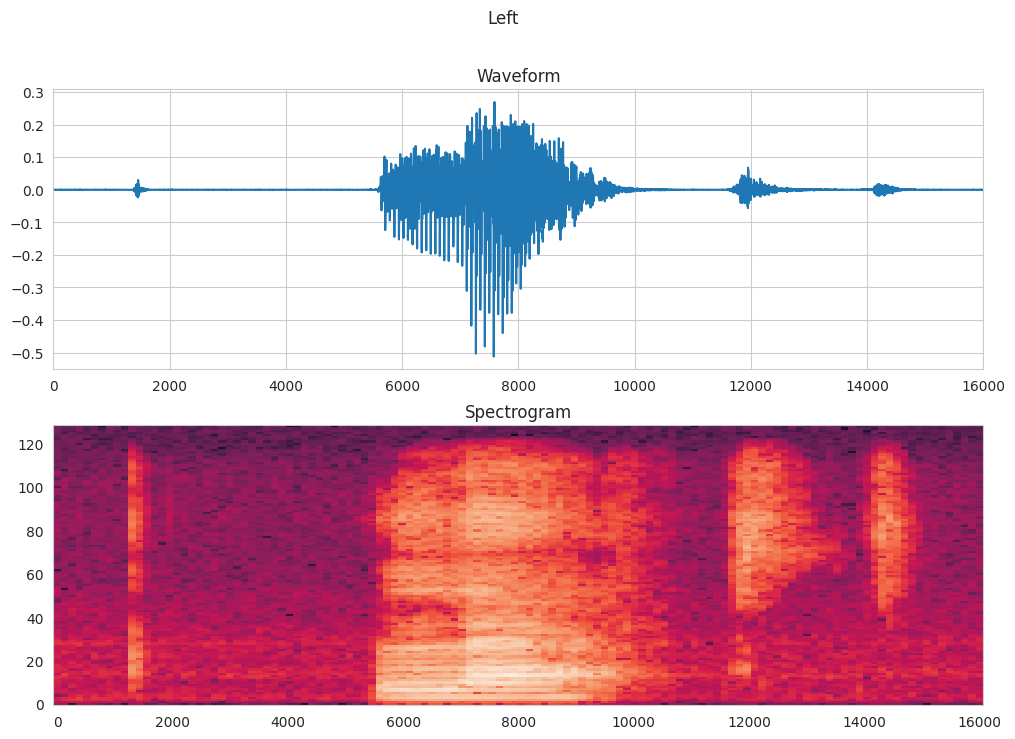

In [14]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()


In [15]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)


In [16]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)


In [17]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break


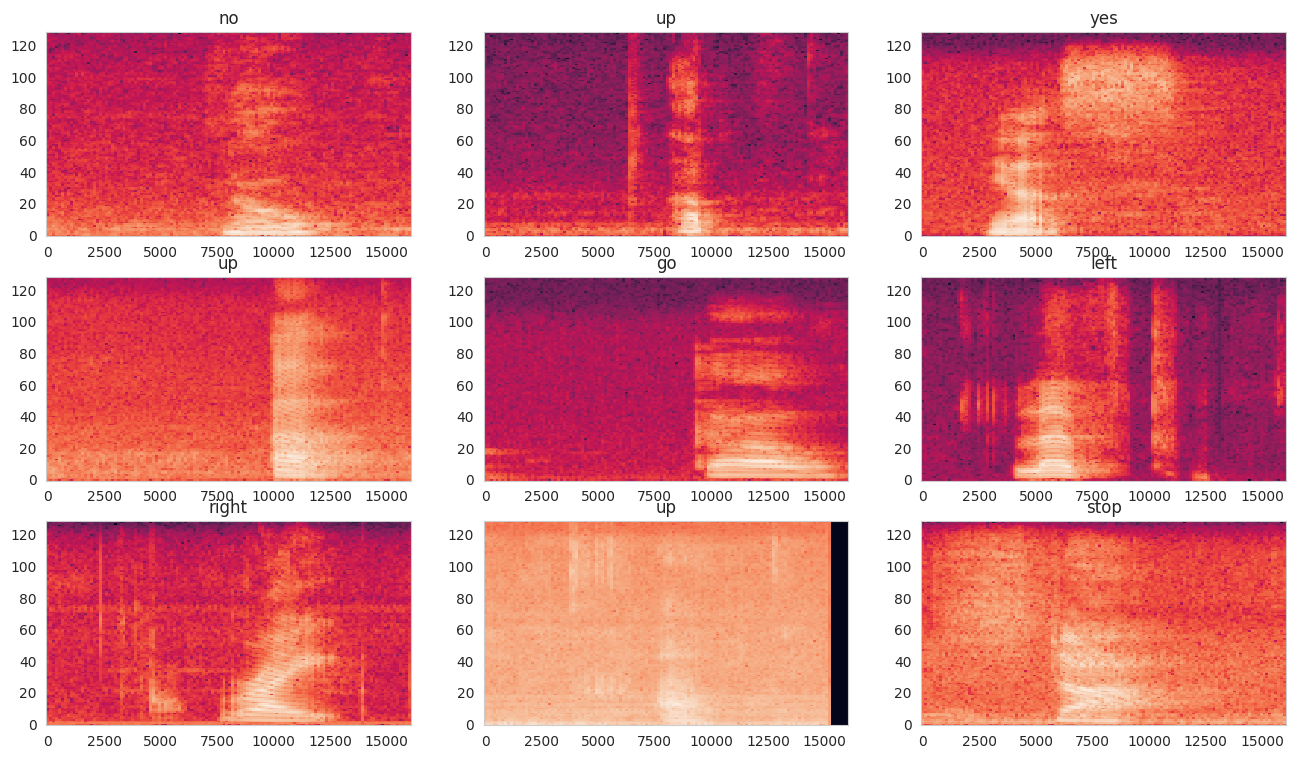

In [18]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()


In [19]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)


In [20]:
def prepare_for_lstm(spectrogram, label):
    # Rewrite shape: (t, f, 1) -> (t, f)
    spectrogram = tf.squeeze(spectrogram, axis=-1)
    return spectrogram, label

In [21]:
train_lstm_ds = train_spectrogram_ds.map(prepare_for_lstm)
val_lstm_ds   = val_spectrogram_ds.map(prepare_for_lstm)
test_lstm_ds  = test_spectrogram_ds.map(prepare_for_lstm)

In [22]:
for spec, label in train_lstm_ds.take(1):
    print(spec.shape)


(64, 124, 129)


2025-11-26 22:44:52.676506: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [23]:
num_classes = len(label_names)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(124, 129)),   # (time, freq)
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 124, 128)       │       132,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,184 (727.28 KB)

 Trainable params: 186,184 (727.28 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history = model.fit(
    train_lstm_ds,
    validation_data=val_lstm_ds,
    epochs=80
)


Epoch 1/80
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7411 - loss: 0.7111 - val_accuracy: 0.6888 - val_loss: 0.8376
Epoch 2/80
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7155 - loss: 0.8078 - val_accuracy: 0.7474 - val_loss: 0.8089
Epoch 3/80
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7688 - loss: 0.6879 - val_accuracy: 0.7760 - val_loss: 0.7327
Epoch 4/80
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8164 - loss: 0.5678 - val_accuracy: 0.7956 - val_loss: 0.6197
Epoch 5/80
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8336 - loss: 0.5027 - val_accuracy: 0.8073 - val_loss: 0.6073
Epoch 6/80
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8516 - loss: 0.4498 - val_accuracy: 0.8112 - val_loss: 0.5580
Epoch 7/80
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.8606 - loss: 0.4326 - val_accuracy: 0.8451 - val_loss: 0.4825
Epoch 8/80
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8666 - loss: 0.4011 - val_accu

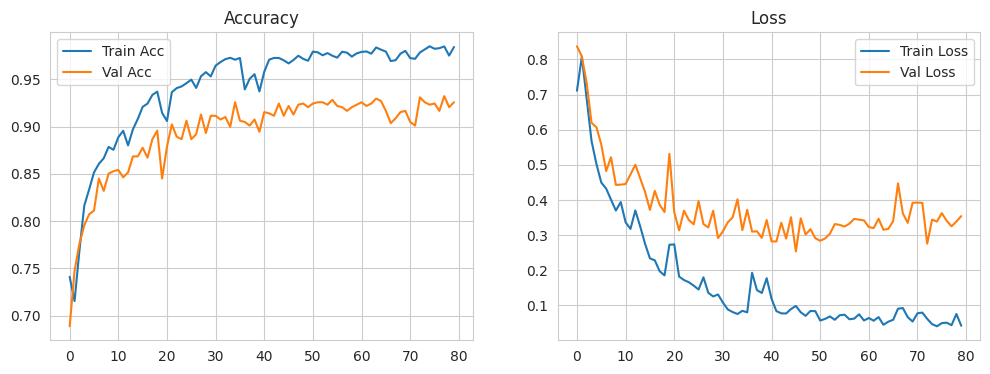

In [27]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, label="Train Acc")
    plt.plot(epochs, val_acc, label="Val Acc")
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Val Loss")
    plt.title("Loss")
    plt.legend()

    plt.show()

plot_history(history)


inferencias


In [32]:
# recuperar audio
test_iter = iter(test_ds)
audio_batch, label_batch = next(test_iter)

print(audio_batch.shape)   # (batch, 16000)
print(label_batch.shape)


(64, 16000)
(64,)


In [35]:
import IPython.display as ipd

idx = 5   # cambiar el índice para sacar audios del batch de test

waveform = audio_batch[idx].numpy()
label = label_batch[idx].numpy()

print("Etiqueta real:", label_names[label])

ipd.Audio(waveform, rate=16000)


Etiqueta real: stop


In [36]:
spec = get_spectrogram(audio_batch[idx])

# Elimina la dimensión de canal para LSTM (si tu modelo no espera canal)
spec = tf.squeeze(spec, axis=-1)

# Expandir batch
spec = tf.expand_dims(spec, axis=0)


In [37]:
pred = model.predict(spec)
pred_label = label_names[pred.argmax()]

print("Predicción del modelo:", pred_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicción del modelo: stop
